In [1]:
import re
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.feature_extraction.text import _document_frequency
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
import scipy.sparse as sp
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
#from keras.regularizers import l2, activity_l2
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.optimizers import Nadam
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
#import word2vecReader
import word2vec
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.casual import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier as RandForest
from sklearn.svm import SVC
from nltk.tokenize import RegexpTokenizer

/home/svetlana/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 960 (0000:01:00.0)


In [2]:
import pandas as pd
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
import re
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
if os.path.exists('business.json'):
    pass
else:
    !wget https://s3.amazonaws.com/cloudfinalprojectsubmission/business.json

if os.path.exists('review.json'):
    pass
else:
    !wget https://s3.amazonaws.com/cloudfinalprojectsubmission/review.json

In [4]:
chunk_size = 10000
business_reader = pd.read_table('business.json', header=None, chunksize=chunk_size)
categories = pd.DataFrame()

for i, chunks in enumerate(business_reader):
    try:

        start_index = chunk_size * i

        for index in range(start_index, start_index + len(chunks)):

            data_json = pd.read_json(chunks[0][index], typ='series')
            # define set of USA cities for loading data
            if data_json['city'] in ['Pittsburgh', 'Charlotte', 'Urbana-Champaign',
                                     'Phoenix', 'Las Vegas', 'Madison']:
                categories = categories.append(data_json[['business_id', 'categories',
                                                          'name', 'review_count']], ignore_index=True)
                
    except:
        pass

categories = categories.drop_duplicates('business_id')
categories = categories.set_index('business_id')


review_reader = pd.read_table('review.json', header=None, chunksize=chunk_size)
reviews_df = pd.DataFrame()

In [5]:
for i, chunks in enumerate(review_reader):
    try:

        start_index = chunk_size * i
        for index in range(start_index, start_index + len(chunks)):
            data_json = pd.read_json(chunks[0][index], typ='series')
            bus_id = data_json['business_id']
            if (bus_id in categories.index.values) and (u'Restaurants' in categories.loc[bus_id].categories):
                reviews_df = reviews_df.append(data_json[['text', 'stars']], ignore_index=True)
                
    except:
        pass

In [6]:
categories.shape

(4943, 3)

In [7]:
reviews_df.head()

,stars,text
0,4.0,Went for breakfast on 6/16/14. We received ver...
1,5.0,I love their stakes and i come here every week...
2,5.0,"Perfect time with hubby, after work which is 4..."
3,5.0,This location never disappoints!! Food is alwa...
4,3.0,Dude... it's Denny's. It's excellent drunk foo...


In [8]:
import random
from copy import deepcopy
from nltk.corpus import wordnet as wn

from nltk.tokenize import word_tokenize

def reduce_duplicates(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def synonyms(sentence):
    syn_dict = []
    for idx, word in enumerate(sentence):
        syn_list = [syn.lemma_names()[0] for syn in wn.synsets(word) 
                                        if word!=syn.lemma_names()[0]]
        if syn_list:              
            syn_dict.append((idx, word ,reduce_duplicates(syn_list)))
    return syn_dict

def change_sentence(sentence, p_coef=0.5, q_coef=0.5):
    try:
        sentence_new = word_tokenize(sentence)
        get = synonyms(sentence_new)
        get_1 = [elem[1] for elem in get]
        p = np.random.geometric(p_coef)
        if p > len(get): #how many words to change
            p = len(get)
        #print('number of words to change: ', p)
        idxes_to_change = random.sample(range(len(get)), p)
        #print('words to change: ', list(np.array(get_1)[idxes_to_change]))
        for idx in idxes_to_change:
            word = get[idx]
            q = np.random.geometric(q_coef)
            if q >= len(word[2]):
                q = len(word[2]) - 1
            #print('q is ', q, word[2][q])
            syn_add = " ".join(word[2][q].split('_'))
            sentence_new[word[0]] = syn_add
            
    except:
        pass
    return " ".join(sentence_new)  

In [10]:
max_len = 200

def lowercase(string):
    return string[:max_len].lower()

reviews_aug = reviews_df['text'].apply(lowercase).apply(change_sentence)



In [11]:
start_token = '#'
end_token = '&'
reviews = reviews_df['text'].values
reviews = [re.sub("[0-9]", "$", x) for x in reviews]
reviews = [re.sub("[^a-zA-Z$ .,!]", "", x) for x in reviews]
reviews = [review + end_token for review in reviews]
reviews = [start_token + '[' + str(int(star)) + ']' + review
           for review, star in zip(reviews, reviews_df.stars.values)]

In [12]:
reviews_aug = reviews_df['text'].apply(lowercase).apply(change_sentence)

reviews_aug = [re.sub("[0-9]", "$", x) for x in reviews_aug]
reviews_aug = [re.sub("[^a-zA-Z$ .,!]", "", x) for x in reviews_aug]
reviews_aug = [review + end_token for review in reviews_aug]
reviews_aug = [start_token + '[' + str(int(star)) + ']' + review
           for review, star in zip(reviews_aug, reviews_df.stars.values)]

In [13]:
len(reviews_aug)

5023

In [14]:
reviews = reviews_aug+reviews


In [15]:
#all unique characters go here
tokens = list(set("".join(reviews)))
print ('n_tokens = ', len(tokens))

('n_tokens = ', 66)


In [16]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t:i for i,t in enumerate(tokens)}

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = {i:t for i,t in enumerate(tokens)}

In [17]:
n_chars = 500
reviews_ix = list(map(lambda review: list(map(token_to_id.get, review)), reviews))

#crop long names and pad short ones
for i in range(len(reviews_ix)):
    reviews_ix[i] = reviews_ix[i][:n_chars] + reviews_ix[i][-1:]  #crop too long
    
    if len(reviews_ix[i]) < n_chars + 1:
        reviews_ix[i] += [token_to_id[" "]] * (n_chars - len(reviews_ix[i]) + 1) #pad too short

assert len(set(map(len, reviews_ix)))==1

reviews_ix = np.array(reviews_ix)

## Lasagne model with data Augmentation

(array([  562.,   571.,   873.,  1501.,  1516.]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ]),
 <a list of 5 Patch objects>)

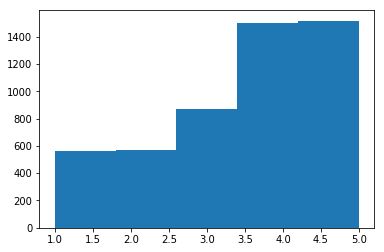

In [18]:
plt.hist(reviews_df.stars.values, bins=5)

In [19]:
reviews_df = reviews_df.append(reviews_df[reviews_df.stars.values < 4.], ignore_index=True)

(array([ 1124.,  1142.,  1746.,  1501.,  1516.]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ]),
 <a list of 5 Patch objects>)

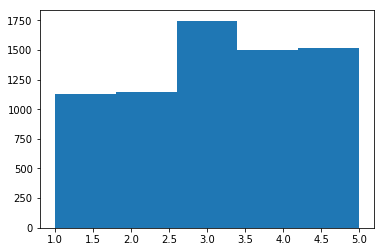

In [20]:
plt.hist(reviews_df.stars.values, bins=5)

In [21]:
input_sequence = T.matrix('token sequencea','int32')
target_values = T.matrix('actual next token','int32')

In [22]:
from lasagne.layers import *

In [30]:
l_in = lasagne.layers.InputLayer(shape=(None, None), input_var=input_sequence)

#!<Your neural network>
#заменили буквы слова на векторы размера 15 (None,None,15) - output
l_emb = EmbeddingLayer(l_in, len(tokens), 15) 

l_rnn = RecurrentLayer(l_emb, 100) #(None,None,50)
l_rnn = LSTMLayer(l_rnn, 256) #(None,None,50)
l_rnn = LSTMLayer(l_rnn, 256) #(None,None,50)

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn, (-1, l_rnn.output_shape[-1]))

l_out = DenseLayer(l_rnn_flat, len(tokens), nonlinearity = T.nnet.softmax)

In [31]:
# Model weights
weights = lasagne.layers.get_all_params(l_out, trainable=True)
network_output = get_output(l_out)

predicted_probabilities_flat = network_output
correct_answers_flat = target_values.ravel()

loss = lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat,correct_answers_flat).mean()

updates = lasagne.updates.adam(loss,weights)

In [32]:
#training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

In [33]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
next_word_probas = network_output.reshape((input_sequence.shape[0], input_sequence.shape[1], len(tokens)))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:,-1]
probs = theano.function([input_sequence], last_word_probas, allow_input_downcast=True)

In [34]:
def generate_sample(seed_phrase=None, N=n_chars, t=1, n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > n_chars:
        seed_phrase = seed_phrase[-n_chars:]
    assert type(seed_phrase) is str

    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = [token_to_id.get(c,0) for c in seed_phrase]
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(len(tokens)), p=p)
            sample_ix.append(ix)

            x = np.hstack((x[-n_chars+1:],[[ix]]))

        random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
        snippets.append(random_snippet)
        
    print("----\n %s \n----" % ';\n'.join(snippets))

In [35]:
def sample_batch(data, batch_size, n_chars=1):
    
    rows = data[np.random.randint(0, len(data), size=batch_size)]
    
    return rows[:,:-1], rows[:,1:]

In [ ]:
print("Training ...")
losses = []

#total N iterations
n_epochs=40

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=64

if os.path.exists('lasagne_weights.npz'):
    with np.load('lasagne_weights.npz') as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(l_out, param_values)
    
for epoch in xrange(n_epochs):
    
    print "Generated reviews"
    generate_sample(n_snippets=1, t=2)

    avg_cost = 0;
    
    start = time.time()
    for _ in range(batches_per_epoch):
        
        x, y = sample_batch(reviews_ix, batch_size)
        avg_cost += train(x, y)
    end = time.time()   
    current_loss = avg_cost / batches_per_epoch
    losses.append(current_loss)
    print("Epoch {} average loss = {} time = {}".format(epoch, current_loss, end - start))
    
np.savez('lasagne_weights.npz', *lasagne.layers.get_all_param_values(l_out))

Training ...
Generated reviews
----
 #[5]I have been going to casbah on a regular basis for the past $ years.the argue for the service is fantastic and a vegan miluse. I cant like to pay  on it to be a bit of a coffee for a business lunch. Whe manighed list are fairly little breading and make a staple but they shod understand the omitoolloom with cutting on their hame time and they always run dumpling.The day I have a price took and it came with inside and were treated entrees as an appetizer and&&                                    
----


In [50]:
for t in [0.5, 0.75, 1., 1.25, 1.5, 2]:
    print '\n\nTemreture = ', t
    for seed in ['#[1]', '#[3]', '#[5]']:
        generate_sample(seed_phrase=seed, n_snippets=10, t=t)



Temreture =  0.5
----
 #[1]ups nOw I had The mushy and that stars has bennwe die to the country Turnand. Really just the Coistels tastrisze. Quckeusf Germ blues,Creek of.Ils throl outsidefing efouls! This stuffed.,tI$ I not, wabk in on VERWicme yet on You.There is a lovely changed icedic. Site, taxpoxt, but she said it us all sincuulzy.. Witphes a lacka Gidato fono.Besss kind of good pizza deluve, delicious,.!!&&                                                                                                               ;
#[1]PRobably oldever . dryings aro the usuchicate deal . we acceptainy Miss .&&                                                                                                                                                                                                                                                                                                                                                                                                      

In [49]:
2+2

4